# Classification des Revenus avec XGBoost sur le Jeu de Données Adult
Ce notebook présente un projet de science des données responsable visant à prédire si une personne gagne plus de 50 000 $ (`>50K`) par an en utilisant le jeu de données **Adult**. Nous utiliserons **XGBoost**, un algorithme d'apprentissage supervisé basé sur les arbres de décision, pour effectuer cette classification.

In [1]:

!pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier
import shap

%matplotlib inline

In [3]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
# Charger les données depuis un fichier CSV
data = pd.read_csv('adult.data', header=None, names=column_names,na_values=" ?")
print(data.head(40))

    age          workclass  fnlwgt      education  education_num  \
0    39          State-gov   77516      Bachelors             13   
1    50   Self-emp-not-inc   83311      Bachelors             13   
2    38            Private  215646        HS-grad              9   
3    53            Private  234721           11th              7   
4    28            Private  338409      Bachelors             13   
5    37            Private  284582        Masters             14   
6    49            Private  160187            9th              5   
7    52   Self-emp-not-inc  209642        HS-grad              9   
8    31            Private   45781        Masters             14   
9    42            Private  159449      Bachelors             13   
10   37            Private  280464   Some-college             10   
11   30          State-gov  141297      Bachelors             13   
12   23            Private  122272      Bachelors             13   
13   32            Private  205019     Assoc-acd

In [4]:
data.info()
missing_percentage = data.isnull().mean() * 100

# Afficher les résultats
print("Pourcentage de valeurs manquantes par colonne :")
print(missing_percentage)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
Pourcentage de valeurs manquantes par colonne :
age               0.000000
workclass         

In [5]:
print(data.isnull().sum())
# Supprimer les lignes contenant des valeurs manquantes
data = data.dropna()

print(f"Nombre de lignes restantes : {len(data)}")
print(data.isnull().sum())


age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64
Nombre de lignes restantes : 30162
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [6]:
# Imputer les valeurs manquantes
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('income')
imputer = SimpleImputer(strategy='most_frequent')
data[categorical_features] = imputer.fit_transform(data[categorical_features])

In [7]:
# Binarisation de l'âge
median_age = data['age'].median()
data['age_binary'] = data['age'].apply(lambda x: 'Young' if x <= median_age else 'Old')
data = data.drop('age', axis=1)

In [8]:
# Prétraitement des variables catégorielles et numériques
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('income')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [9]:
# Séparer les caractéristiques et la cible
X = data.drop('income', axis=1)
y = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

In [10]:

# Diviser les données en 80% pour entraînement+validation et 20% pour le test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Diviser les 80% restants en 70% pour l'entraînement et 20% pour la validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Afficher les proportions
print(f"Taille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de validation : {len(X_val)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")


Taille de l'ensemble d'entraînement : 21716
Taille de l'ensemble de validation : 5429
Taille de l'ensemble de test : 3017


In [11]:
# Pipeline avec XGBoost
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
clf_pipeline.fit(X_train, y_train)

C:\Users\kerim\PycharmProjects\pythonProject\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['fnlwgt', 'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country',
                                                   'age_binary'])])),
                ('classifier',
                 XGBClassi...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Rapport de Classification :
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      2266
           1       0.77      0.68      0.72       751

    accuracy                           0.87      3017
   macro avg       0.83      0.80      0.82      3017
weighted avg       0.86      0.87      0.87      3017

Exactitude : 0.8684
F1 Score : 0.7186


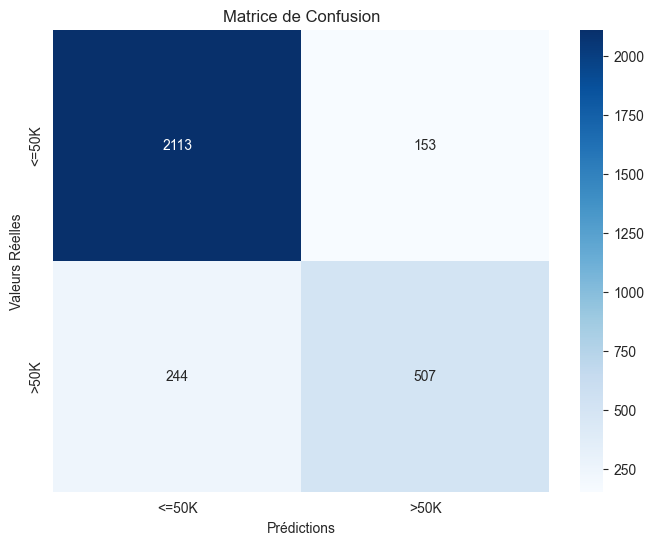

In [12]:


# Prédire les résultats sur l'ensemble de test
y_pred = clf_pipeline.predict(X_test)

# Imprimer le rapport de classification
print("Rapport de Classification :\n", classification_report(y_test, y_pred))
print(f"Exactitude : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Créer une heatmap pour visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()
